### dev dn

In [1]:
import os
from sklearn.datasets import fetch_covtype
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [2]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig, TabNetModelConfig, NodeConfig, AutoIntConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig

In [3]:
from pytorch_tabular.utils import get_balanced_sampler, get_class_weighted_cross_entropy

In [4]:
def load_classification_data():
    dataset = fetch_covtype(data_home="data")
    data = np.hstack([dataset.data, dataset.target.reshape(-1, 1)])
    col_names = [f"feature_{i}" for i in range(data.shape[-1])]
    col_names[-1] = "target"
    data = pd.DataFrame(data, columns=col_names)
    data["feature_0_cat"] = pd.qcut(data["feature_0"], q=4)
    data["feature_0_cat"] = "feature_0_" + data.feature_0_cat.cat.codes.astype(str)
    test_idx = data.sample(int(0.2 * len(data)), random_state=42).index
    test = data[data.index.isin(test_idx)]
    train = data[~data.index.isin(test_idx)]
    return (train, test, ["target"])

def print_metrics(y_true, y_pred, tag):
    if isinstance(y_true, pd.DataFrame) or isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame) or isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    if y_true.ndim>1:
        y_true=y_true.ravel()
    if y_pred.ndim>1:
        y_pred=y_pred.ravel()
    val_acc = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred)
    print(f"{tag} Acc: {val_acc} | {tag} F1: {val_f1}")
    
def make_mixed_classification(n_samples, n_features, n_categories):
    X,y = make_classification(n_samples=n_samples, n_features=n_features, random_state=42, n_informative=5)
    cat_cols = random.choices(list(range(X.shape[-1])),k=n_categories)
    num_cols = [i for i in range(X.shape[-1]) if i not in cat_cols]
    for col in cat_cols:
        X[:,col] = pd.qcut(X[:,col], q=4).codes.astype(int)
    col_names = [] 
    num_col_names=[]
    cat_col_names=[]
    for i in range(X.shape[-1]):
        if i in cat_cols:
            col_names.append(f"cat_col_{i}")
            cat_col_names.append(f"cat_col_{i}")
        if i in num_cols:
            col_names.append(f"num_col_{i}")
            num_col_names.append(f"num_col_{i}")
    X = pd.DataFrame(X, columns=col_names)
    y = pd.Series(y, name="target")
    data = X.join(y)
    return data, cat_col_names, num_col_names

def print_metrics(y_true, y_pred, tag):
    if isinstance(y_true, pd.DataFrame) or isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame) or isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    if y_true.ndim>1:
        y_true=y_true.ravel()
    if y_pred.ndim>1:
        y_pred=y_pred.ravel()
    val_acc = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred)
    val_auc = roc_auc_score(y_true, y_pred)
    print(f"{tag} Acc: {val_acc} \n {tag} F1: {val_f1} \n {tag} AUC: {val_auc}")

In [19]:
data, cat_col_names, num_col_names = make_mixed_classification(
    n_samples=10000, n_features=200, n_categories=40)
train, test = train_test_split(data, random_state=42)
train, val = train_test_split(train, random_state=42)

In [5]:
from compare_control import *
from clean_questions import *
from predict_digestive import *

In [6]:
questionnaire = 'all'
idp = 'all'
question_visits = [2]
impute_flag = True

df = load_patient_grouped(questionnaire=questionnaire, idp=idp, 
                     question_visits=question_visits, imputed=impute_flag, 
                     patient_grouping='simplified')

/home/fs0/syzhang/.conda/envs/bbk/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (2446,2447,2448,2449,2450,2451,2452,2453,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2561,2562,2563,2564,2565,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2576,2577,2578,2579,2580,2581,2582,2583,2584,2585,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622,2623,2624,2625,2626,2627,2628,2629,2740,2741,2742,2743,2744,2745,2746,2747,2748,2751,2821,2822,2823,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835,2836,2837,2838,2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2

Questionnaires from visits [2] shape=(4342, 962)
After imputation shape=(4342, 956)


In [49]:
df = load_digestive_data(label_type='severe', questionnaire=questionnaire, idp=idp, 
                         question_visits=question_visits, imputed=impute_flag)

/home/fs0/syzhang/.conda/envs/bbk/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (2441,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451,2452,2453,2454,2455,2456,2457,2499,2500,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559,2560,2561,2562,2563,2564,2565,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2576,2577,2578,2579,2580,2581,2582,2583,2584,2585,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605,2606,2607,2742,2743,2810,2811,2812,2813,2814,2815,2816,2817,2818,2819,2820,2821,2822,2823,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835,2836,2837,2838,2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,3000,3001,3002,3003,3004) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(3951, 3797)
Questionnaires from visits [2] shape=(3951, 962)
After imputation shape=(3951, 953)


In [12]:
df = load_patient_matched(questionnaire=questionnaire, idp=idp, 
                          question_visits=question_visits, imputed=impute_flag)

/home/fs0/syzhang/.conda/envs/bbk/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2446,2447,2448,2449,2450,2451,2452,2453,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2561,2562,2563,2564,2565,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2576,2577,2578,2579,2580,2581,2582,2583,2584,2585,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622,2623,2624,2625,2626,2627,2628,2629,2740,2741,2742,2743,2744,2745,2746,2747,2748,2751,2821,2822,2823,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835,2836,2837,2838,2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2

Patients=4342, controls=4376
Questionnaires from visits [2] shape=(8718, 962)
After imputation shape=(8718, 956)


In [7]:
# remove time cols
for col in df.columns:
    if col!='label' and col!='eid': # exclude label
        # remove time stamp cols
        if df[col].dtype==object:
            df.drop(col, axis=1, inplace=True)

In [8]:
1- df['label'].sum()/df.shape[0]

0.39175495163519114

In [9]:
df.drop(['eid'],axis=1,inplace=True)

In [51]:
train, test = train_test_split(df, random_state=42)
train, val = train_test_split(train, random_state=42)

In [52]:
target_col = 'label'
clf = lgb.LGBMClassifier(random_state=42, n_jobs=-1)
clf.fit(train.drop(columns=target_col), train[target_col].values.ravel())
val_pred = clf.predict(val.drop(columns=target_col))
print_metrics(val[target_col], val_pred, "Validation")
test_pred = clf.predict(test.drop(columns=target_col))
print_metrics(test[target_col], test_pred, "Holdout")

Validation Acc: 0.6612685560053981 
 Validation F1: 0.12543554006968644 
 Validation AUC: 0.5054623258936063
Holdout Acc: 0.6659919028340081 
 Holdout F1: 0.17499999999999996 
 Holdout AUC: 0.5231388517031087


In [12]:
col_names = train.columns.to_list()
# col_names

In [321]:
data_config = DataConfig(
    target=[target_col], #target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=col_names,
#     categorical_cols=cat_col_names,
#     continuous_feature_transform="quantile_normal",
#     normalize_continuous_features=True
)
trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=512,
    max_epochs=100,
    gpus=0, #index of the GPU to use. 0, means CPU
)
optimizer_config = OptimizerConfig()
# model_config = CategoryEmbeddingModelConfig(
#     task="classification",
#     layers="128-64-32",  # Number of nodes in each layer
#     activation="LeakyReLU", # Activation between each layers
#     learning_rate = 1e-3,
#     metrics=["accuracy","f1"],
#     metrics_params=[{},{"num_classes":2}]
# )
# model_config = TabNetModelConfig(
#     task="classification",
# #     learning_rate = 1e-3,
# #     n_d = 16,
# #     n_a = 16,
#     metrics=["accuracy","f1"],
#     metrics_params=[{},{"num_classes":2}]
# )
model_config = AutoIntConfig(
    task="classification",
    attn_embed_dim=8,
    num_attn_blocks=1,
    metrics=["accuracy","f1"],
    metrics_params=[{},{"num_classes":2}]
)
# model_config = NodeConfig(
#     task="classification",
#     num_trees=128,
#     metrics=["accuracy","f1"],
#     metrics_params=[{},{"num_classes":2}]
# )
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

In [322]:
sampler = get_balanced_sampler(train[target_col].values.ravel())

In [ ]:
tabular_model.fit(train=train, validation=val, train_sampler=sampler)
# tabular_model.fit(train=train, validation=val)

/home/fs0/syzhang/.conda/envs/bbk/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory saved_models exists and is not empty. With save_top_k=1, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type             | Params
--------------------------------------------------
0 | backbone     | AutoIntBackbone  | 15.8 K
1 | dropout      | Dropout          | 0     
2 | output_layer | Linear           | 15.3 K
3 | loss         | CrossEntropyLoss | 0     
/home/fs0/syzhang/.conda/envs/bbk/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

In [282]:
result = tabular_model.evaluate(test)

/home/fs0/syzhang/.conda/envs/bbk/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': tensor(0.4530),
 'test_f1': tensor(0.4530),
 'train_accuracy': tensor(0.4966),
 'train_f1': tensor(0.4966),
 'train_loss': tensor(0.8835),
 'valid_accuracy': tensor(0.4693),
 'valid_f1': tensor(0.4693),
 'valid_loss': tensor(0.7349)}
--------------------------------------------------------------------------------


In [268]:
pred_df = tabular_model.predict(test)

Generating Predictions...:   0%|          | 0/3 [00:00<?, ?it/s]

In [269]:
pred_df['prediction'].value_counts()

 0.825723    681
-1.211060    405
Name: prediction, dtype: int64

In [270]:
tmp = pred_df['prediction']>0
preds = tmp.astype(int)

In [271]:
test[target_col].value_counts()

1    687
0    399
Name: label, dtype: int64

In [272]:
print_metrics(test[target_col], preds, tag="Holdout")

Holdout Acc: 0.9760589318600368 
 Holdout F1: 0.9809941520467836 
 Holdout AUC: 0.9758238390736667


In [304]:
# tabular_model.save_model("examples/basic")
loaded_model = TabularModel.load_from_checkpoint("examples/basic")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [305]:
train, test = train_test_split(df, random_state=4)
train, val = train_test_split(train, random_state=4)

In [306]:
result = loaded_model.evaluate(test)

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['20486-0.0', '20527-0.0', '20458-0.0'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

#### using pytorch tabnet

In [21]:
train, test = train_test_split(df, random_state=42)
train, val = train_test_split(train, random_state=42)

In [23]:
train.shape

(2442, 955)

In [24]:
train.drop(columns=target_col).shape

(2442, 954)

In [25]:
X_train = train.drop(columns=target_col).values
y_train = train[target_col].values
X_valid = val.drop(columns=target_col).values
y_valid = val[target_col].values
X_test = test.drop(columns=target_col).values
y_test = test[target_col].values

##### balance before split

In [9]:
# balance before train test split
y = df['label']
# y = pd.get_dummies(y_label).iloc[:,0]
X = df.drop(['label','eid'], axis=1)
# balance dataset
from imblearn.under_sampling import RandomUnderSampler
# define undersampling strategy
under = RandomUnderSampler(random_state=0)
# fit and apply the transform
X, y = under.fit_resample(X, y)

In [15]:
X.shape

(3402, 954)

In [14]:
pd.concat([X,y], axis=1).shape

(3402, 955)

In [16]:
train, test = train_test_split(pd.concat([X,y], axis=1), random_state=42)
train, val = train_test_split(train, random_state=42)

In [17]:
train.shape

(1913, 955)

In [19]:
target_col = 'label'
X_train = train.drop(columns=target_col).values
y_train = train[target_col].values
X_valid = val.drop(columns=target_col).values
y_valid = val[target_col].values
X_test = test.drop(columns=target_col).values
y_test = test[target_col].values

##### pretrain

In [42]:
import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    pretraining_ratio=0.8,
)

Device used : cpu
epoch 0  | loss: 243259217.1793| val_0_unsup_loss: 804035840.0|  0:00:02s
epoch 1  | loss: 188592218.0115| val_0_unsup_loss: 822827456.0|  0:00:04s
epoch 2  | loss: 144148542.15996| val_0_unsup_loss: 889916608.0|  0:00:07s
epoch 3  | loss: 107567392.31364| val_0_unsup_loss: 633984960.0|  0:00:09s
epoch 4  | loss: 96313416.65238| val_0_unsup_loss: 336004448.0|  0:00:11s
epoch 5  | loss: 90034332.93048| val_0_unsup_loss: 211233904.0|  0:00:14s
epoch 6  | loss: 82636874.50915| val_0_unsup_loss: 157121328.0|  0:00:16s
epoch 7  | loss: 98779997.84631| val_0_unsup_loss: 142237520.0|  0:00:18s
epoch 8  | loss: 65444114.2666| val_0_unsup_loss: 149335152.0|  0:00:20s
epoch 9  | loss: 53856249.15003| val_0_unsup_loss: 159313712.0|  0:00:22s
epoch 10 | loss: 65568803.09462| val_0_unsup_loss: 151027088.0|  0:00:25s
epoch 11 | loss: 58382322.03136| val_0_unsup_loss: 134400976.0|  0:00:27s
epoch 12 | loss: 22649702.5886| val_0_unsup_loss: 117314448.0|  0:00:29s
epoch 13 | loss: 156

In [43]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [44]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

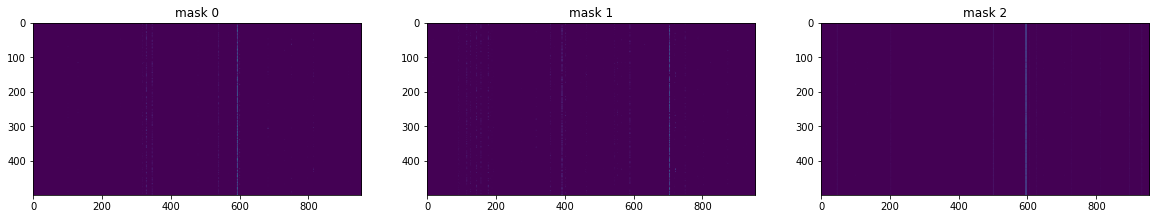

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:500])
    axs[i].set_title(f"mask {i}")

In [46]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip
Device used : cpu
Device used : cpu


##### real train

In [47]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import torch

clf = TabNetClassifier(
#     n_d=64, n_a=64, n_steps=5,
#     gamma=1.5, n_independent=2, n_shared=2,
#     cat_idxs=cat_idxs,
#     cat_dims=cat_dims,
#     cat_emb_dim=1,
#     lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_name=['valid'],
    eval_metric=['auc','balanced_accuracy'],
    max_epochs=1000, patience=20,
    batch_size=256, virtual_batch_size=128,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain
)
preds = clf.predict(X_test)

Device used : cpu
Loading weights from unsupervised pretraining


/home/fs0/syzhang/.conda/envs/bbk/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.71956 | valid_auc: 0.47936 | valid_balanced_accuracy: 0.48784 |  0:00:02s
epoch 1  | loss: 0.69316 | valid_auc: 0.51902 | valid_balanced_accuracy: 0.5027  |  0:00:04s
epoch 2  | loss: 0.69344 | valid_auc: 0.50316 | valid_balanced_accuracy: 0.5     |  0:00:06s
epoch 3  | loss: 0.68332 | valid_auc: 0.48404 | valid_balanced_accuracy: 0.5     |  0:00:08s
epoch 4  | loss: 0.66672 | valid_auc: 0.50278 | valid_balanced_accuracy: 0.51001 |  0:00:10s
epoch 5  | loss: 0.69007 | valid_auc: 0.51037 | valid_balanced_accuracy: 0.49723 |  0:00:13s
epoch 6  | loss: 0.68884 | valid_auc: 0.50439 | valid_balanced_accuracy: 0.49591 |  0:00:15s
epoch 7  | loss: 0.67245 | valid_auc: 0.52334 | valid_balanced_accuracy: 0.50519 |  0:00:17s
epoch 8  | loss: 0.67218 | valid_auc: 0.54317 | valid_balanced_accuracy: 0.5034  |  0:00:19s
epoch 9  | loss: 0.67668 | valid_auc: 0.51582 | valid_balanced_accuracy: 0.51073 |  0:00:21s
epoch 10 | loss: 0.6644  | valid_auc: 0.49605 | valid_balanced_accurac

In [48]:
print_metrics(test[target_col], preds, tag="Holdout") # nd default 512 batch

Holdout Acc: 0.5464159811985899 
 Holdout F1: 0.5804347826086956 
 Holdout AUC: 0.5509828009828011


In [21]:
print_metrics(test[target_col], preds, tag="Holdout") # nd64 256 batch

Holdout Acc: 0.6197247706422019 
 Holdout F1: 0.5930289641629849 
 Holdout AUC: 0.620171608794572


In [199]:
print_metrics(test[target_col], preds, tag="Holdout") # pretrain 256 batch

Holdout Acc: 0.5662983425414365 
 Holdout F1: 0.5950128976784179 
 Holdout AUC: 0.5889122369241881


In [197]:
print_metrics(test[target_col], preds, tag="Holdout") # pretrain 512 batch

Holdout Acc: 0.570902394106814 
 Holdout F1: 0.660844250363901 
 Holdout AUC: 0.5384421753072638


In [188]:
print_metrics(test[target_col], preds, tag="Holdout") # pretrain 1024 b

Holdout Acc: 0.5506445672191529 
 Holdout F1: 0.6463768115942029 
 Holdout AUC: 0.5150758993553753


In [161]:
print_metrics(test[target_col], preds, tag="Holdout") # no pretrain 1024

Holdout Acc: 0.6003683241252302 
 Holdout F1: 0.7360097323600973 
 Holdout AUC: 0.49921747600442157


In [27]:
imp = clf.feature_importances_

In [28]:
tmp = train.drop(columns=target_col).columns
q_codes = tmp[imp>0]

In [29]:
len(q_codes)

101

In [30]:
match_question(q_codes, questionnaire='all', idp='all')

[array(['Weighted-mean L2 in tract acoustic radiation (right)'],
       dtype=object),
 array(['Age when attended assessment centre'], dtype=object),
 array(['Volume of grey matter in Temporal Fusiform Cortex, posterior division (left)'],
       dtype=object),
 array(['Volume of grey matter in VIIIb Cerebellum (right)'], dtype=object),
 array(['Weighted-mean FA in tract inferior fronto-occipital fasciculus (left)'],
       dtype=object),
 array(['Volume of grey matter in Superior Frontal Gyrus (left)'],
       dtype=object),
 array(['Median T2star in putamen (right)'], dtype=object),
 array(['Attempted suicide in past year'], dtype=object),
 array(['Weighted-mean MD in tract forceps minor'], dtype=object),
 array(['Mean OD in tapetum on FA skeleton (left)'], dtype=object),
 array(['Been in serious accident believed to be life-threatening'],
       dtype=object),
 array(['Volume of grey matter in Paracingulate Gyrus (right)'],
       dtype=object),
 array(['Mean ICVF in sagittal stratum

In [33]:
explain_matrix, masks = clf.explain(X_test)

In [37]:
mask0_cols = np.where(masks[0].sum(axis=0))

In [38]:
q_codes = tmp[mask0_cols]

In [39]:
match_question(q_codes, questionnaire='all', idp='all')

[array(['Weighted-mean L2 in tract acoustic radiation (right)'],
       dtype=object),
 array(['Volume of grey matter in Temporal Fusiform Cortex, posterior division (left)'],
       dtype=object),
 array(['Weighted-mean MD in tract forceps minor'], dtype=object),
 array(['Mean OD in tapetum on FA skeleton (left)'], dtype=object),
 array(['Been in serious accident believed to be life-threatening'],
       dtype=object),
 array(['Volume of grey matter in Paracingulate Gyrus (right)'],
       dtype=object),
 array(['Mean ICVF in sagittal stratum on FA skeleton (left)'],
       dtype=object),
 array(['Mean FA in superior longitudinal fasciculus on FA skeleton (right)'],
       dtype=object),
 array(['Mean L2 in middle cerebellar peduncle on FA skeleton'],
       dtype=object),
 array(['Mean L3 in superior longitudinal fasciculus on FA skeleton (left)'],
       dtype=object),
 array(['Mean MD in posterior limb of internal capsule on FA skeleton (left)'],
       dtype=object),
 array(['Mean

In [40]:
explain_matrix, masks = clf.explain(X_test)

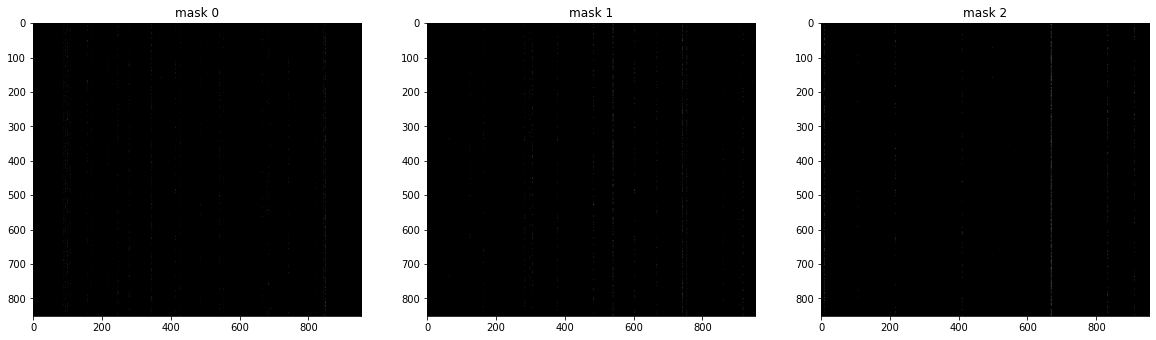

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:1000], cmap='gray')
    axs[i].set_title(f"mask {i}")